In [1]:
from pyprind.progbar import ProgBar
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

### Algoritmos 

In [2]:
class regressao_logistica:
    def __init__(self, X, y, tipo='gradiente', epochs=1_00, learning_rate=0.01, salvar_processo=False):
        # Adicionando a coluna interceptor
        self.X_ = np.c_[ np.ones(shape=(X.shape[0], 1), dtype=np.float32), X]


        # Tipo de alg usado
        self.tipo   = tipo

        # Caso seja de multiclasse muda a estrategia
        self.multiclasse = True if len(np.unique(y))>2 else False
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.salvar_processo = salvar_processo

        if self.multiclasse:
            self.classes = np.unique(y)
            self.coeficientes = np.random.rand( len(self.classes), self.X_.shape[1])
        else:
            self.coeficientes  = np.random.rand(1, self.X_.shape[1])


        # Fazendo reshape na target caso necessario
        self.y  = y.reshape(-1, 1) if len(y.shape) == 1 else y

        #Se for multiclasse é feito o one hot encoding
        if self.multiclasse and self.y.shape[1] == 1:
            onehot = np.zeros((self.X_.shape[0], len(self.classes)))
            for i, c in enumerate(self.classes):
                onehot[:, i] = (self.y.ravel() == c).astype(float)
            self.y = onehot

    def ajuste(self):
        match self.tipo:
            case 'gradiente': 
                self.gradiente()
            case _: 
                self.gradiente()
    
    def gradiente(self):
        progbar = ProgBar(self.epochs, title='Treinando modelo - gradiente', stream=1)
        self.processo = []
        M = self.X_.shape[0]
        for epoch in range(self.epochs):
            # Faz a predição com base se é multiclasses ou não
            pred = self.predicao_ajuste(self.X_)

            # Caso seja multiclasse usará a função softmax caso contrario a sigmoid
            pred = self.sigmoid(pred) if not(self.multiclasse) else self.softmax(pred)  

            grad = self.learning_rate * ((1/M) * (self.y - pred).T.dot(self.X_))

            self.coeficientes -= grad

            perda = self.cross_entropy(pred)

            progbar.update(1, item_id=f'Epoch {epoch} - perda {perda:.4f}')
            if self.salvar_processo: 
                self.processo.append( perda )
    
 
    def cross_entropy(self, pred):
        return -1*np.mean(
            self.y * np.log1p(pred) + ( 1 - self.y ) * np.log1p(1 -  pred)
        )

    # Função sigmoid
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    # Função sofmax para multiclasses
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def predicao_ajuste(self, x):
        return np.dot(x, self.coeficientes.T)

    def predicao(self, x):
        M = x.shape[0]
        x_ = np.c_[ np.ones(shape=(M, 1), dtype=np.float32), x]

        if self.multiclasse:
            return np.argmax(self.softmax(np.dot(x_,self.coeficientes.T)), axis=1).reshape(-1, 1)
            
        return self.sigmoid(np.dot(x_,self.coeficientes.T))


`Gassian`

In [3]:
class Gaussian:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.classes = np.unique(y)
        # Quantidade de classes, instancias e colunas sucessivamente
        self.S = len(self.classes)
        self.N = self.X.shape[0]
        self.M = self.X.shape[1]

    def ajuste(self):
        # Cria uma array para guardar objetos [omega e pi]
        self.omega_pi = np.empty((self.S, self.S), dtype=object)
        self.sigma = np.zeros((self.M, self.M))
        for c in range(self.S):

            # Seleciona o array contendo uma respetiva classe
            sub_x = self.X[np.hstack(self.y == c), :] 

            # Calcula omega e pi
            self.omega_pi[c, 0] = len(sub_x)/self.N
            self.omega_pi[c, 1] = np.mean(sub_x, axis=0)
        
            sub_x = self.X[np.hstack(self.y == c), :]
            self.sigma += (sub_x - self.omega_pi[c, 1]).T.dot( (sub_x - self.omega_pi[c, 1]) )
            

        self.sigma = self.sigma/self.N 
        self.sigma_inv = np.linalg.inv(self.sigma)  
        return self
    
    def predicao(self, x):      
        deltas = []
        for c in range(self.S):
            pi_c = self.omega_pi[c, 0]
            om_c = self.omega_pi[c, 1]

            parte_1 = x @ self.sigma_inv @ om_c 
            parte_2 = 0.5 * om_c.T @ self.sigma_inv @ om_c + np.log(pi_c)
            
            delta = parte_1 - parte_2
            deltas.append(delta)

        deltas = np.array(deltas) 
        pred = np.array(self.classes[np.argmax(deltas, axis=0)])
        return pred.reshape(-1, 1)


`Naive bayes`

In [4]:
class NaiveBayesGaussiano:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
        self.classes = np.unique(y)
        # Quantidade de classes, instancias e colunas sucessivamente
        self.S = len(self.classes)  
        self.N = self.X.shape[0]    
        self.M = self.X.shape[1]
    
    def ajuste(self):
        # Cria uma array para guardar objetos [omega e pi]
        self.omega_pi = np.empty((self.S, 2), dtype=object)
        self.sigma_diag = np.zeros((self.S, self.M))
        for c in range(self.S):
            # Seleciona o array contendo uma respetiva classe
            sub_x = self.X[np.hstack(self.y == self.classes[c]), :]
            N_k = len(sub_x)
            
            # PI = N_k / N
            self.omega_pi[c, 0] = N_k / self.N
            
            # omega_dk = MEAN(x_id)
            self.omega_pi[c, 1] = np.mean(sub_x, axis=0)
            
            # Variância diagonal
            self.sigma_diag[c, :] = np.var(sub_x, axis=0, ddof=0)

        return self
            
          

    def predicao(self, x):

        deltas = []
        
        for c in range(self.S):
            pi_c = self.omega_pi[c, 0]  
            om_c = self.omega_pi[c, 1]  
            var_c = self.sigma_diag[c, :] 
          
            # parte 1
            parte_1 = np.sum(x * om_c / var_c, axis=1) - 0.5 * np.sum(om_c**2 / var_c)
            
            # parte 2
            parte_2 = 0.5 * np.sum(np.log(2 * np.pi * var_c)) - np.log(pi_c)
            
            deltas.append(parte_1 - parte_2)
        deltas = np.array(deltas)
        
        pred =  np.array(self.classes[np.argmax(deltas, axis=0)])

        return pred.reshape(-1, 1)

`Metricas`

As funções calcula a acuracia global e por classe

In [5]:
def acuracia(ytrue, ypred):
    return np.divide((ytrue == ypred).astype(int).sum(), ytrue.shape[0])

def acuracia_por_classe(ytrue, ypred):
    dicionario = { 'classes':[],  'total':[], 'acertos':[], 'acuracia':[] }

    for i in np.unique(ytrue, sorted=True):
        acertos = np.sum((ytrue == i) & (ypred == i))
        total   = np.sum(ytrue == i)
        
        acuracia_i = round(acertos / total, 5)

        dicionario['classes'].append(f'rotulo {i}')
        dicionario['total'].append(total)
        dicionario['acertos'].append(acertos)
        dicionario['acuracia'].append(acuracia_i)

    
    result = pd.DataFrame(dicionario)
    return result.set_index('classes')

Função abaixo dividi dados de treino e teste

In [6]:
def train_test(X, y, test_size = 0.2, seed=1):
    rnd = np.random.RandomState(seed)

    index = np.arange(X.shape[0])
    rnd.shuffle(index)
    test_index = index[:int(X.shape[0] * test_size)]
    train_index = index[int(X.shape[0] * test_size):]

    xtest = X[test_index]
    ytest = y[test_index]

    xtrain = X[train_index]
    ytrain = y[train_index]

    return xtrain, ytrain, xtest, ytest

Verficia a media e desvio padrão da acucaria por classe

In [7]:
def trat_dfs_acu_por_classe(result):
    dfs = [df for sublist in result for df in sublist]

    for i, df in enumerate(dfs):
        df['fold'] = i + 1

    df_geral = pd.concat(dfs).reset_index()
    return df_geral.groupby('classes')[['total','acertos','acuracia']].agg(['mean', 'std'])

&nbsp;

---------------

# Questão 1

In [8]:
from sklearn.preprocessing import StandardScaler

Considere o conjunto de dados disponível em breastcancer.csv, organizado em 31 colunas, sendo as 30 primeiras colunas os atributos e a última coluna a saída. Os 30 atributos coletados de exames médicos são usados no diagnóstico do câncer de mama, sendo 1 a classe positiva e 0 a classe negativa. Maiores detalhes sobre os dados podem ser conferidos em https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset.

In [9]:
# Lendo arquivo
breast = np.loadtxt(fname='dataset\\breastcancer.csv', delimiter=',')
breast.shape

(569, 31)

In [10]:
X = breast[:, :30].astype(np.float32)
X_scalery = breast[:, -1].astype(np.float32).reshape(-1, 1)

In [11]:
y = breast[:, 30:].astype(np.float32)

In [12]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

In [13]:
xtrain, ytrain, xtest, ytest = train_test(X_scaler, y)

In [14]:
ytrain.shape, xtrain.shape

((456, 1), (456, 30))

## a. Considerando uma validação cruzada em 10 folds, avalie modelos de classificação binária nos dados em questão. Para tanto, use as abordagens abaixo:

In [15]:
def folds(X, y, modelo, test_size=0.25, k=10, metrics=[], metrics_df=[]):
    metrics_list = []
    metrics_list_df = []
    for i in range(k):
        xtrain_fold, ytrain_fold, xtest_fold, ytest_fold = train_test(X, y, test_size, seed=None)

        model = modelo(xtrain_fold, ytrain_fold)
        model.ajuste()

        pred = model.predicao(xtest_fold)
        
        pred = (pred >= 0.5).astype(int) if not(np.any(pred.astype(int)==1)) else pred
        
        metrics_list.append([i(ytest_fold, pred) for i in metrics])
        metrics_list_df.append([i(ytest_fold, pred) for i in metrics_df])
    
    return metrics_list, metrics_list_df

`Logistica GD`

In [16]:
result_log, result_log_df = folds(xtrain, ytrain, regressao_logistica, metrics=[acuracia], metrics_df=[acuracia_por_classe])

Treinando modelo - gradiente
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoch 99 - perda -0.6111
Total time elapsed: 00:00:00
Treinando modelo - gradiente
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoch 99 - perda -0.5944
Total time elapsed: 00:00:00
Treinando modelo - gradiente
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoch 99 - perda -0.6032
Total time elapsed: 00:00:00
Treinando modelo - gradiente
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoch 99 - perda -0.6000
Total time elapsed: 00:00:00
Treinando modelo - gradiente
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoch 99 - perda -0.6182
Total time elapsed: 00:00:00
Treinando modelo - gradiente
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoch 99 - perda -0.6034
Total time elapsed: 00:00:00
Treinando modelo - gradiente
0% [##############################] 100% | ETA: 00:00:00 | Item I

`gaussiano`

In [17]:
result_adg, result_adg_df  = folds(xtrain, ytrain, Gaussian, metrics=[acuracia], metrics_df=[acuracia_por_classe])

`Naive bayes`

In [18]:
result_naive,  result_naive_df = folds(xtrain, ytrain, NaiveBayesGaussiano, metrics=[acuracia], metrics_df=[acuracia_por_classe])

## b) Para cada modelo criado, reporte valor médio e desvio padrão da acurácia global e da acurácia por classe.

### Acuracia

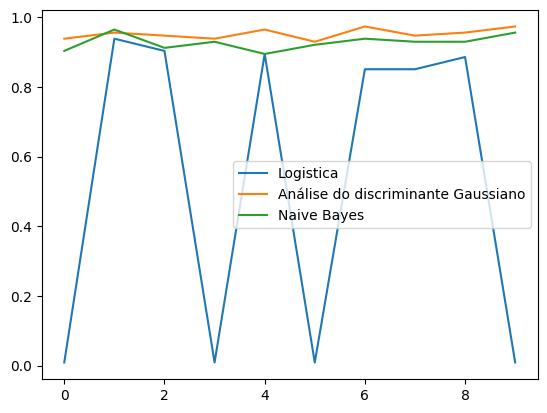

In [19]:
plt.plot(result_log, label='Logistica')
plt.plot(result_adg, label='Análise do discriminante Gaussiano')
plt.plot(result_naive, label='Naive Bayes')
plt.legend()
plt.show()

In [20]:
results = pd.DataFrame({
    'Logistica':[ np.mean(result_log),np.std(result_log)],
    'Análise do discriminante Gaussiano':[ np.mean(result_adg),  np.std(result_adg)],
    'Naive Bayes':[np.mean(result_naive), np.std(result_naive)],
}, index=['Média', 'Desvio Padrão'])

results

,Logistica,Análise do discriminante Gaussiano,Naive Bayes
Média,0.535965,0.952632,0.928070
Desvio Padrão,0.431102,0.014253,0.020684


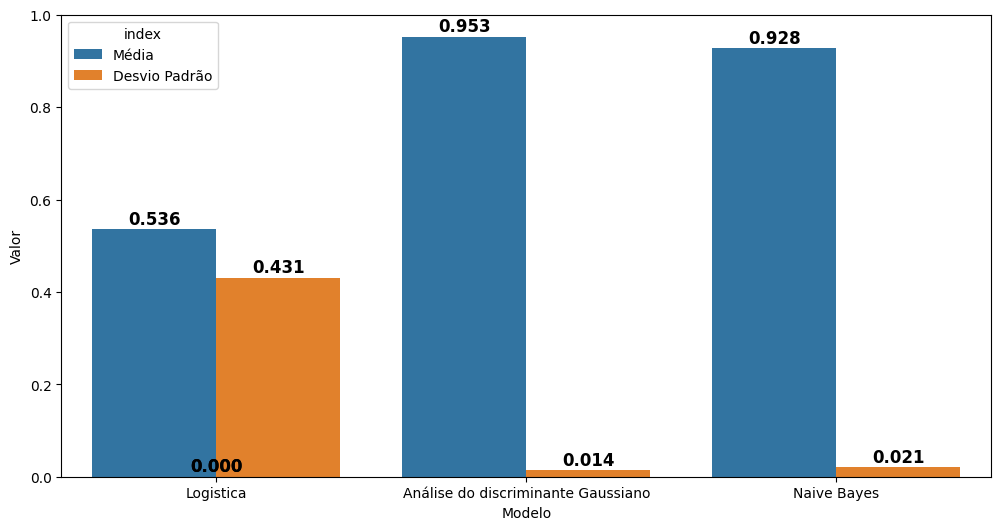

In [21]:
results_melt = results.reset_index().melt(id_vars='index', var_name='Modelo', value_name='Valor')

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=results_melt, x='Modelo', y='Valor', hue='index')

for p in ax.patches:
    valor = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2, valor + 0.002,
        f'{valor:.3f}',
        ha='center', va='bottom', fontsize=12, fontweight='bold'
    )
    
plt.show()

### Acuracia por classe

In [22]:
trat_dfs_acu_por_classe(result_log_df)

total           acertos             acuracia          
            mean       std    mean        std      mean       std
classes                                                          
rotulo 0.0  71.0  3.399346    37.5  32.585784  0.525027  0.453601
rotulo 1.0  43.0  3.399346    23.6  19.693202  0.552434  0.457094

In [23]:
trat_dfs_acu_por_classe(result_adg_df)

total           acertos            acuracia          
            mean       std    mean       std      mean       std
classes                                                         
rotulo 0.0  67.7  4.762119    66.9  4.458450  0.988454  0.009106
rotulo 1.0  46.3  4.762119    41.7  3.713339  0.902415  0.030961

In [24]:
trat_dfs_acu_por_classe(result_naive_df)

total           acertos            acuracia          
            mean       std    mean       std      mean       std
classes                                                         
rotulo 0.0  70.6  3.777124    68.8  4.366539  0.974250  0.022830
rotulo 1.0  43.4  3.777124    37.0  2.867442  0.853711  0.034406

&nbsp;

-----------

# Questão 2

Considere o conjunto de dados disponível em vehicle.csv, organizado em 19 colunas, sendo as 18 primeiras colunas os atributos e a última coluna a saída. Os 18 atributos caracterizam a silhueta de veículos, extraídos pelo método HIPS (Hierarchical Image Processing System). A tarefa consiste em classificar o veículo em 4 classes (bus, opel, saab, e van). Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/search?type=data&sort=runs&id=54.

In [25]:
veiculos = np.loadtxt(fname='dataset\\vehicle.csv', delimiter=',')

In [26]:
X = veiculos[:, :18].astype(np.float32)
y = veiculos[:, 18:]

In [27]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

In [28]:
xtrain, ytrain, xtest, ytest = train_test(X_scaler, y)

## 1. Considerando uma validação cruzada em 10 folds, avalie modelos de classificação multiclasse nos dados em questão. Para tanto, use as abordagens abaixo:

* Regressão softmax (treinado com GD ou SGD);
* Análise do discriminante Gaussiano;
* Naive Bayes Gaussiano;

`SGD`

In [29]:
result_log, result_log_df  = folds(xtrain, ytrain, regressao_logistica, metrics=[acuracia], metrics_df=[acuracia_por_classe])

Treinando modelo - gradiente
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoch 99 - perda -0.4439
Total time elapsed: 00:00:01
Treinando modelo - gradiente
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoch 99 - perda -0.4347
Total time elapsed: 00:00:00
Treinando modelo - gradiente
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoch 99 - perda -0.4022
Total time elapsed: 00:00:00
Treinando modelo - gradiente
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoch 99 - perda -0.4191
Total time elapsed: 00:00:00
Treinando modelo - gradiente
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoch 99 - perda -0.4263
Total time elapsed: 00:00:00
Treinando modelo - gradiente
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoch 99 - perda -0.4220
Total time elapsed: 00:00:00
Treinando modelo - gradiente
0% [##############################] 100% | ETA: 00:00:00 | Item I

`gaussian`

In [30]:
result_adg, result_adg_df  = folds(xtrain, ytrain, Gaussian, metrics=[acuracia], metrics_df=[acuracia_por_classe])

`naive bayes`

In [31]:
result_naive,  result_naive_df = folds(xtrain, ytrain, NaiveBayesGaussiano, metrics=[acuracia], metrics_df=[acuracia_por_classe])

## 2. Para cada modelo criado, reporte valor médio e desvio padrão da acurácia global e da acurácia por classe.

`Acuracia`

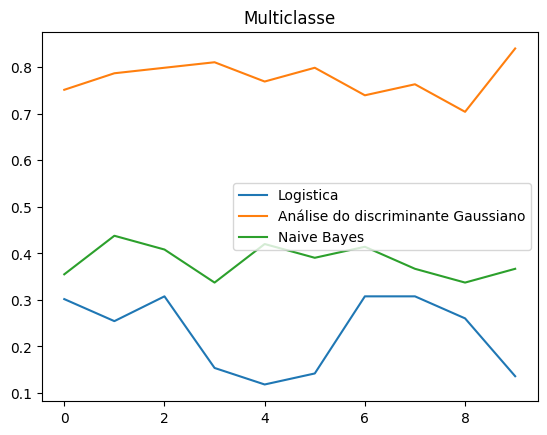

In [32]:
plt.title('Multiclasse')
plt.plot(result_log, label='Logistica')
plt.plot(result_adg, label='Análise do discriminante Gaussiano')
plt.plot(result_naive, label='Naive Bayes')
plt.legend()
plt.show()

In [33]:
results = pd.DataFrame({
    'Logistica':[ np.mean(result_log),np.std(result_log)],
    'Análise do discriminante Gaussiano':[ np.mean(result_adg),  np.std(result_adg)],
    'Naive Bayes':[np.mean(result_naive), np.std(result_naive)],
}, index=['Média', 'Desvio Padrão'])

results

,Logistica,Análise do discriminante Gaussiano,Naive Bayes
Média,0.228994,0.776331,0.383432
Desvio Padrão,0.077198,0.037123,0.033971


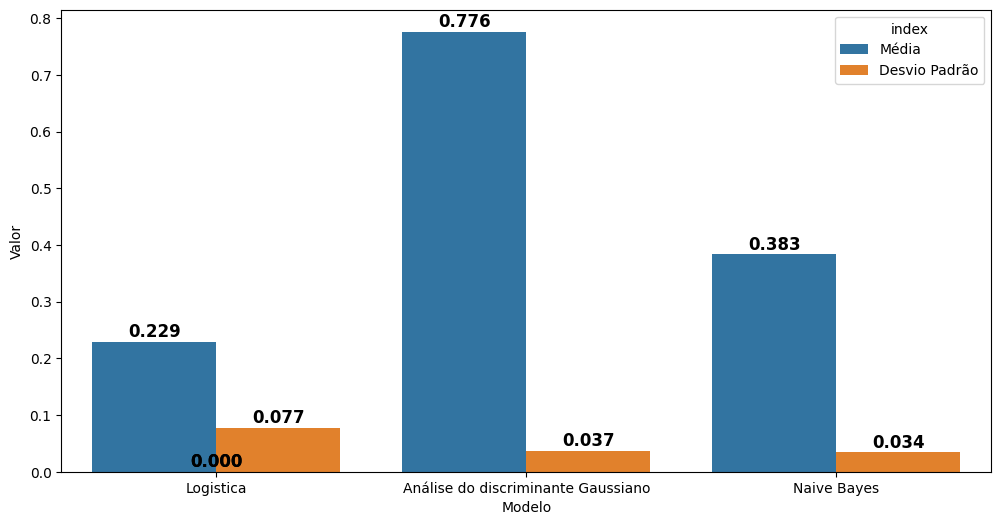

In [34]:
results_melt = results.reset_index().melt(id_vars='index', var_name='Modelo', value_name='Valor')

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=results_melt, x='Modelo', y='Valor', hue='index')

for p in ax.patches:
    valor = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2, valor + 0.002,
        f'{valor:.3f}',
        ha='center', va='bottom', fontsize=12, fontweight='bold'
    )
    
plt.show()

`Acuracia por classe`

In [35]:
trat_dfs_acu_por_classe(result_log_df)

total           acertos             acuracia          
            mean       std    mean        std      mean       std
classes                                                          
rotulo 0.0  46.3  5.186521     9.5   8.343327  0.218970  0.199313
rotulo 1.0  39.4  6.719788    12.7  12.918978  0.305404  0.286314
rotulo 2.0  46.0  3.496029     9.5   8.618456  0.210231  0.195603
rotulo 3.0  37.3  6.000926     7.0  10.349450  0.185340  0.290314

In [36]:
trat_dfs_acu_por_classe(result_adg_df)

total           acertos            acuracia          
            mean       std    mean       std      mean       std
classes                                                         
rotulo 0.0  43.4  6.785606    41.7  6.307843  0.961724  0.024722
rotulo 1.0  41.3  4.762119    27.4  3.921451  0.665369  0.075432
rotulo 2.0  44.4  3.169297    25.2  3.765339  0.567975  0.077946
rotulo 3.0  39.9  5.586691    36.9  4.557046  0.927369  0.044956

In [37]:
trat_dfs_acu_por_classe(result_naive_df)

total           acertos            acuracia          
            mean       std    mean       std      mean       std
classes                                                         
rotulo 0.0  43.9  4.306326     0.6  1.074968  0.012709  0.022608
rotulo 1.0  41.9  3.034981    21.8  7.997222  0.521476  0.180655
rotulo 2.0  44.7  5.907622     7.0  7.257180  0.160697  0.173594
rotulo 3.0  38.5  3.100179    35.4  4.141927  0.917697  0.050757